# Clustering Yelp Restaurants

**Part 1: To be completed INDIVIDUALLY and due on October 14 at 7pm.**

In this assignment, we will be working with the [Yelp dataset](https://drive.google.com/open?id=0B4bdB5WPHGsqcmJMNmxzQmQ3aTQ). You can find the format of the dataset [here](https://www.yelp.com/dataset_challenge).

From the Business Objects, let's try to find culinary districts in Las Vegas. These are characterized by closeness and similarity of restaurants. Use the "longitude" and "latitude" to cluster closeness. Use "categories" to cluster for similarity. You may want to use only a subset (15-20) of popular categories.

Note that the spatial coordinates and restaurant categories have different units of scale. Your results could be arbitrarily skewed if you don't incorporate some scaling.

Find clusters using the 3 different techniques we discussed in class: k-means++, hierarchical, and GMM. Explain your data representation and how you determined certain parameters (for example, the number of clusters in k-means++). **(30 pts)**

In [5]:
import json
import pandas as pd
from pandas import DataFrame
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sklearn.datasets as sk_data
import sklearn.metrics as metrics
from sklearn.cluster import KMeans
import time
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

#import matplotlib as mpl
import seaborn as sns
%matplotlib inline
r_in_LV = []
# read line by line through data
with open('yelp_academic_dataset_business.json') as b_data:
    for each_B in b_data:
        data = json.loads(each_B)
        # get restaurants business in LV from data
        if 'Las Vegas' in data['city'] and 'Restaurants' in data['categories']:
            r_in_LV.append(data)
            
            


In [6]:
# get top 20 categories
all_cat = []
for res in r_in_LV:
    for cat in res['categories']:
        all_cat.append(cat)
import collections
counter=collections.Counter(all_cat)
top_cat = counter.most_common()[0:20]

In [7]:
# get rid of categories like 'restaurants' 'Fast food' and 'food'
filtered_cat = []
for i in range(len(top_cat)):
    if top_cat[i][0] != 'Restaurants' and top_cat[i][0] != 'Fast Food' and top_cat[i][0] != 'Food':
        filtered_cat.append(top_cat[i])

In [8]:
# get restaurants whose categories contain at least one category in top 20 category
top_cat_list = [i[0] for i in filtered_cat]
filtered_r = []
for res in r_in_LV:
    if len(set.intersection(set(res['categories']),set(top_cat_list)))!= 0:
        filtered_r.append(res)

In [9]:
# get coordinate from restaurants list
coordinate_list = []
cat_list = []
for r in filtered_r:
    tmp = []
    tmp.append(r['longitude'])
    tmp.append(r['latitude'])
    coordinate_list.append(tmp)
    cat_list.append(r['categories'])

In [10]:
# convert list of strings to a huge string in list.(for countvectorizer)
cat_list_str = [];
for c in cat_list:
    str1 = ' '.join(c)
    cat_list_str.append(str1.lower())

In [11]:
# convert to lowercase. (for countvectorizer)
top_cat_list = [x.lower() for x in top_cat_list]

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(vocabulary=top_cat_list)
cv_fit=cv.fit_transform(cat_list_str)
cat_Matrix = cv_fit.toarray()

In [13]:
# scale two matrix so that they have same unit
from sklearn.preprocessing import scale
from sklearn.preprocessing import normalize
from sklearn import preprocessing
# times 4 to let coordinate have more weight
scaled_coordinate = scale(coordinate_list)*4
scaled_cat_list = scale(cat_Matrix)

/Users/haotianwu/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [14]:
# combine two matrix
scaled_coordinate = scaled_coordinate.tolist()
scaled_cat_list = scaled_cat_list.tolist()
for i in range(len(scaled_coordinate)):
    for cat in scaled_cat_list[i]:
        scaled_coordinate[i].append(cat)

In [15]:
re_matrix = np.matrix(scaled_coordinate)
kmean_matrix = re_matrix

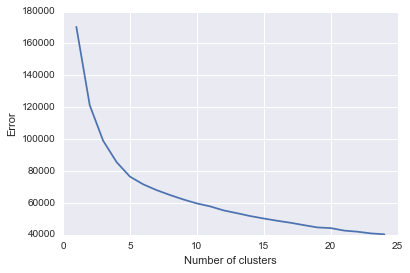

In [16]:
# use the following two plots to decide how many clusters should be used
error = np.zeros(25)
for k in range(1,25):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=20)
    kmeans.fit_predict(kmean_matrix)
    error[k] = kmeans.inertia_
plt.plot(range(1,len(error)),error[1:])
plt.xlabel('Number of clusters')
dummy = plt.ylabel('Error')

In [17]:
def sc_evaluate_clusters(X,max_clusters):
    s = np.zeros(max_clusters+1)
    s[0] = 0;
    s[1] = 0;
    for k in range(2,max_clusters+1):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
        kmeans.fit_predict(X)
        s[k] = metrics.silhouette_score(X,kmeans.labels_,metric='cosine')
    plt.plot(range(2,len(s)),s[2:])
    plt.xlabel('Number of clusters')
    plt.ylabel('Adjusted Rand Index')

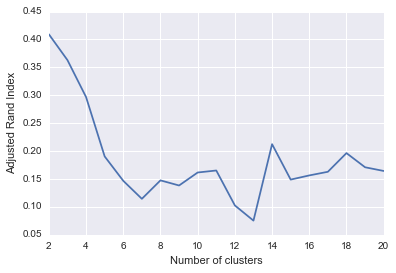

In [18]:
sc_evaluate_clusters(re_matrix,20)

In the errors plot, the more cluster you have, the less errors will be. But more clusters means more running time.
And in Adjusted Rand Index plot, 9 cluster,13 cluster and 18 cluster seems have better adjusted rand index.
To avoid messy in the plot, I choose 9 cluster.

In [19]:
# do kmeans
kmeans = KMeans(init='k-means++', n_clusters=9, n_init=10)
t0 = time.time()
kmeans.fit_predict(kmean_matrix)
t_batch = time.time() - t0

In [20]:
# do hierarchical
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
cluster_num = 12
model = AgglomerativeClustering(linkage='ward',n_clusters=cluster_num)
agg_matrix = re_matrix
model.fit(agg_matrix)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward',
            memory=Memory(cachedir=None), n_clusters=12, n_components=None,
            pooling_func=<function mean at 0x108d7d048>)

In [21]:
from sklearn import mixture
from sklearn.mixture import GMM

In [22]:
# do gmm
gm_matrix = re_matrix
gm = mixture.GMM(n_components=10,covariance_type='spherical')
gm.fit(gm_matrix)

GMM(covariance_type='spherical', init_params='wmc', min_covar=0.001,
  n_components=10, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)

Visualize the clusters by plotting the longitude/latitude of the restaurants in a scatter plot. Label each cluster with a category. In a markdown, explain how labels are assigned. **(10 pts)**

Note that some categories are inherently more common (e.g. "pizza"). When labeling your clusters, you want to avoid the scenario where all clusters are labeled as "pizza" simply because of the uniformly large number of these restaurants across all clusters. In other words, we don’t want to point out that pizza restaurants are pretty much evenly distributed in high quantities everywhere, but rather discover when they, or another type of restaurant, appear in notably high quantities.

In kmeans and hierarchical:
For each cluster, I find the percentage of each category.
So for example, in cluster 1, 'Mexican' appears 500, 'Chinese' appears 300,'Japanese'appears, so mexican is 50% in cluster 1.
After I get all thest percentage, I compare all these percentage by categories.
For example, mexican in cluster 1 is 50%, in cluster 2 is 60%, in cluster 3 is 70%. 70% is the highest. So in las vegas, the mexican culinary district is cluster 3.
I did it for every cluster and every category and I also limit the appearance of the final label.
In gmm:
I use prob_()function to get each probability of each data in each cluster. And for each cluster, I get 100 restaruants with highest probablity. Acording to these restaurants, I get 2 most popular category as label for each cluster.

In [23]:
# find elements in cluster
def ClusterIndicesNumpy(clustNum, labels_array): 
    return np.array([i for i, x in enumerate(labels_array) if x == clustNum])

In [24]:
def find_label(n,metric_label):
    label = []
    for index in ClusterIndicesNumpy(n, metric_label):
        for cat in filtered_r[index]['categories']:
            label.append(cat)
    label_counter=collections.Counter(label)
    area_label = []
    for i in range(8):
        cat = (label_counter.most_common())[i]
        if  cat[0] != 'Restaurants' and cat[0] != 'Fast Food' and cat[0] != 'Food':
            area_label.append(cat)
    return area_label

In [25]:
# get sum in list of tuple
def find_sum(tuple_list):
    label_sum = 0
    for x in tuple_list:
        label_sum += x[1]
    return label_sum

In [26]:
def find_related_label_kmeans(n_cluster,metric_label):    
    all_cluster_label = []
    for i in range(n_cluster):
        tmp = find_label(i,metric_label)
        all_cluster_label.append(tmp)
    percent_label = []
    for cluster in all_cluster_label:
        tmp_list=[]
        label_sum = find_sum(cluster)
        for label in cluster:
            tmp_t = (label[0],label[1]/label_sum)
            tmp_list.append(tmp_t)
        percent_label.append(tmp_list)
    label_dict = {}
    for i in range(len(percent_label)):
        for label in percent_label[i]:
            if label[0] not in label_dict:
                label_dict[label[0]] = []
                tmp_tuple = (label[1],i)
                label_dict[label[0]].append(tmp_tuple)
            else:
                tmp_tuple = (label[1],i)
                label_dict.get(label[0]).append(tmp_tuple)
    kmean_cluster_label = []
    for i in range(n_cluster):
        tmp = []
        kmean_cluster_label.append(tmp)
    for label in label_dict:
        sorted_label_p = (sorted(label_dict[label], key=lambda x: x[1]))[0:5]
        for n in range(len(sorted_label_p)):
            t = (label,sorted_label_p[n][0])
            kmean_cluster_label[sorted_label_p[n][1]].append(t)
    new_area_label = []
    for l in kmean_cluster_label:
        new_label = sorted(l,key = lambda x : x[1],reverse = True)
        if len(new_label) <2:
            new_area_label.append(new_label[0][0])
        else:
            new_area_label.append(new_label[0][0] + '/' + new_label[1][0])
    return new_area_label

In [27]:
import colorsys
# get n unique colors for plotting
def get_colors(num_colors):
    colors=[]
    for i in np.arange(0., 360., 360. / num_colors):
        hue = i/360.
        lightness = (50 + np.random.rand() * 10)/100.
        saturation = (90 + np.random.rand() * 10)/100.
        colors.append(colorsys.hls_to_rgb(hue, lightness, saturation))
    return colors

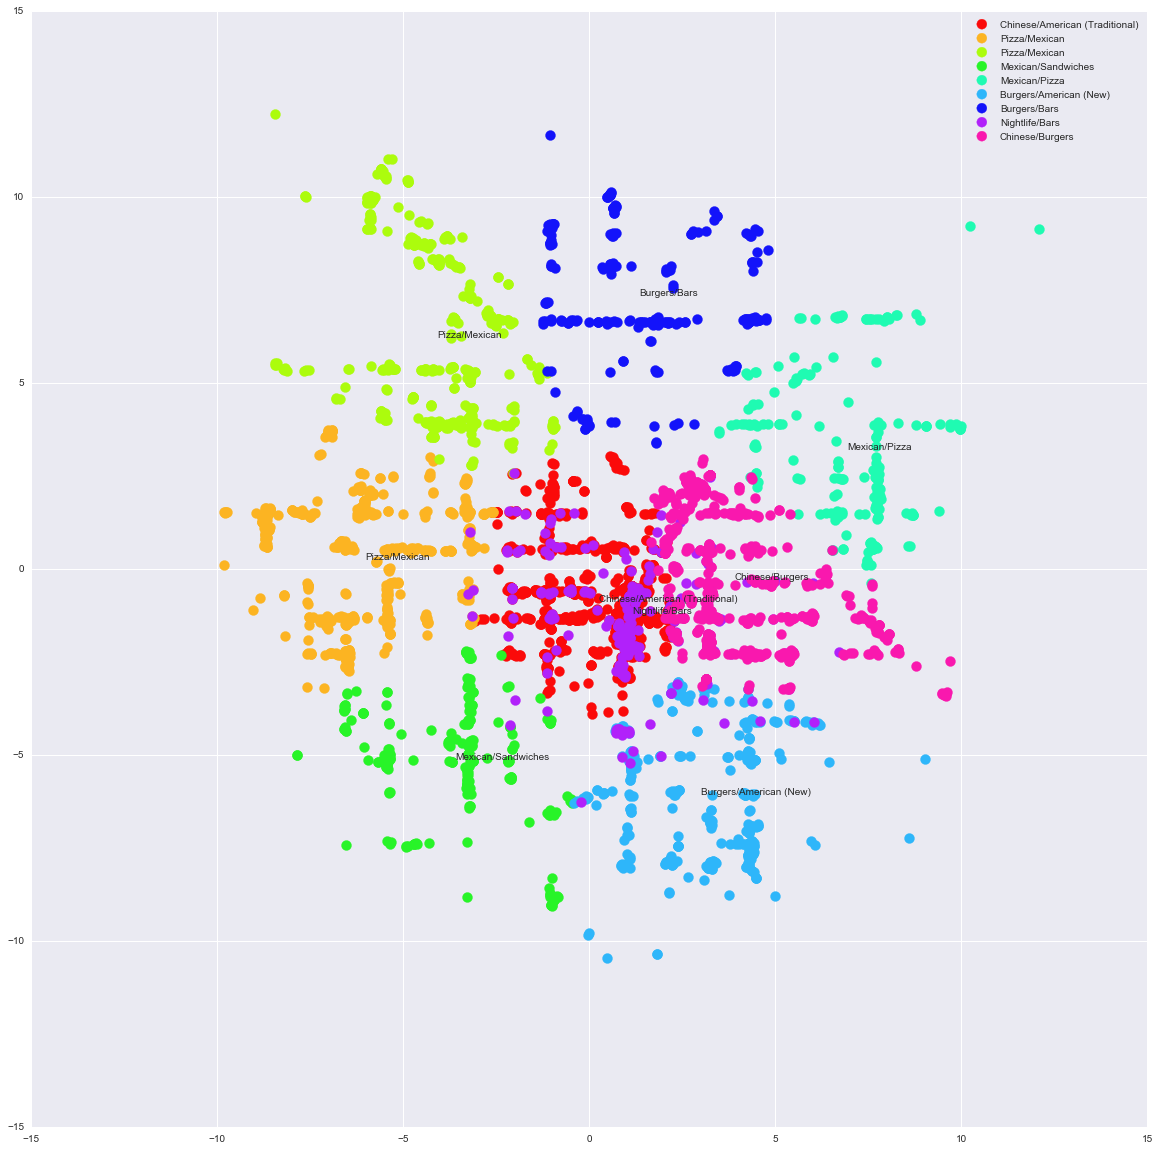

In [28]:
fig = plt.figure(figsize=(20,20))
# colors = ['lightblue', 'orange', 'lightgreen','grey','black','cyan','pink','white','red','green','blue','purple','darkgreen','darkblue']
colors = get_colors(len(kmeans.cluster_centers_))
label_color = [colors[l] for l in kmeans.labels_]
all_labels = find_related_label_kmeans(len(kmeans.cluster_centers_),kmeans.labels_)
# plt.scatter(kmean_matrix[:,0], kmean_matrix[:,1],c=label_color,s=100)
# plt.legend(loc='upper right')
for i in range(len(kmeans.cluster_centers_)):
    label = all_labels[i]
    x = kmeans.cluster_centers_[i][0]
    y = kmeans.cluster_centers_[i][1]
    plt.annotate(label, xy=(x,y), xytext=(x, y))

for i in range(len(kmeans.cluster_centers_)):
    index = ClusterIndicesNumpy(i,kmeans.labels_)
    x = []
    y = []
    for j in range(len(index)):
        x.append(kmean_matrix[index[j],0])
        y.append(kmean_matrix[index[j],1])
    plt.scatter(x, y, color=colors[i],s=100,label = all_labels[i])
plt.legend(loc='upper right')

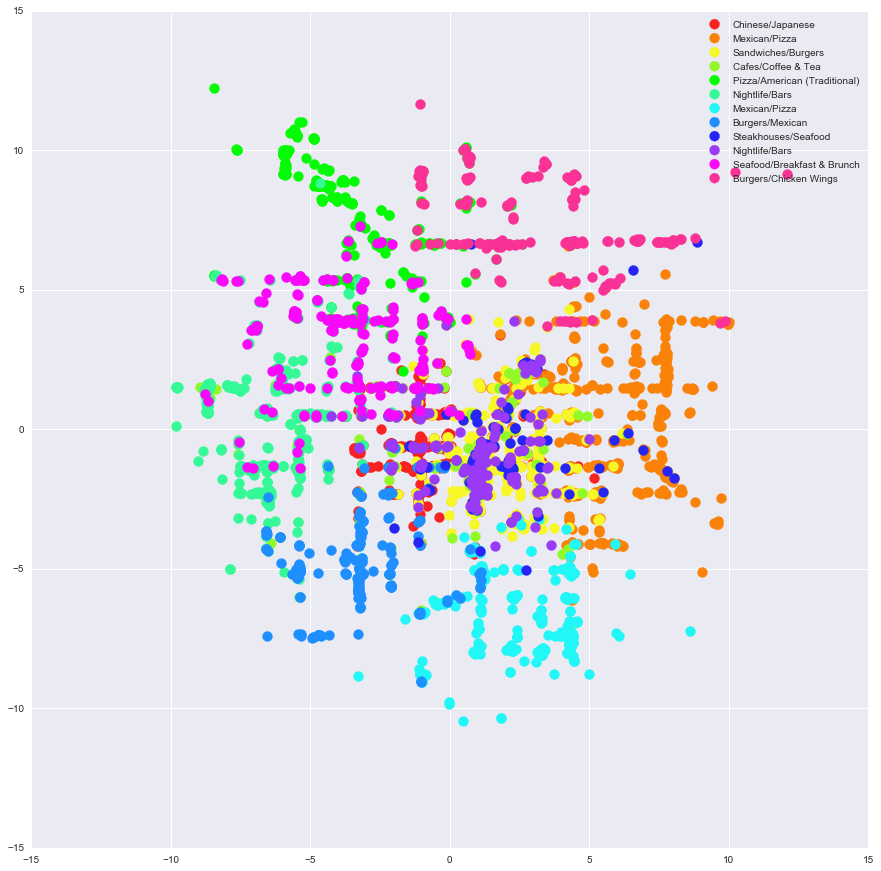

In [29]:
plt.figure(figsize=(15,15))
colors = get_colors(cluster_num)
labels = find_related_label_kmeans(cluster_num,model.labels_)
for i in range(cluster_num):
    index = ClusterIndicesNumpy(i,model.labels_)
    x = []
    y = []
    for j in range(len(index)):
        x.append(agg_matrix[index[j],0])
        y.append(agg_matrix[index[j],1])
    plt.scatter(x, y, color=colors[i],s=100,label = labels[i])
plt.legend(loc='upper right')

In [30]:
prob_matrix = gm.predict_proba(gm_matrix)
gmm_c = []
for i in range(10):
    tmp = []
    gmm_c.append(tmp)

In [31]:
for r in range(len(prob_matrix)):
    max_prob = [0,0]
    for i in range(len(prob_matrix[r])):
        if prob_matrix[r][i] > max_prob[0]:
            max_prob[0] = prob_matrix[r][i]
            max_prob[1] = i
    gmm_c[max_prob[1]].append(r)

In [32]:
gmm_cluster_label = []
for i in range(10):
    df = pd.DataFrame((gm.predict_proba(re_matrix))[:,i],columns = ['c'])
    c = df['c'].copy()
    c.sort(ascending = False)
    index_list = (c[0:100].index).tolist()
    cat_cluster = []
    for i in index_list:
        for cat in filtered_r[i]['categories']:
            if  cat != 'Restaurants' and cat != 'Fast Food' and cat != 'Food':
                cat_cluster.append(cat)
    counter=collections.Counter(cat_cluster)
    gmm_cluster_label.append(counter.most_common())
filtered_gmm_c_label = []
for cluster in gmm_cluster_label:
    tmp = cluster[0][0] + '/' + cluster[1][0]
    filtered_gmm_c_label.append(tmp)

/Users/haotianwu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


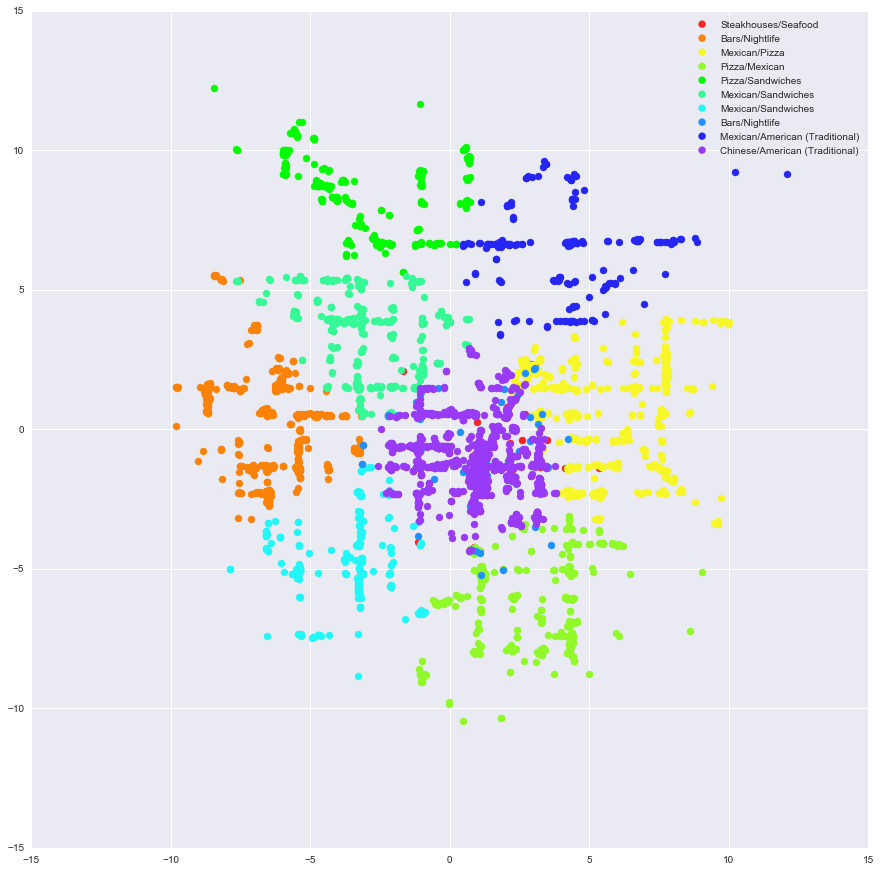

In [33]:
plt.figure(figsize=(15,15))
for i in range(10):
    index = gmm_c[i]
    x = []
    y = []
    for j in range(len(index)):
        x.append(gm_matrix[index[j],0])
        y.append(gm_matrix[index[j],1])
    plt.scatter(x, y, color=colors[i],s=50,label = filtered_gmm_c_label[i])
plt.legend(loc='upper right')

Now let's detect outliers. These are the ones who are the farthest from the centroids of their clusters. Track them down and describe any interesting observations that you can make. **(10 pts)**

In [34]:
import math
# find outliers by calculating distance
def distance(x1,y1,x2,y2):
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

In [35]:
# compare and get the restaurants with farthest distance
all_outliers = []
for i in range(len(kmeans.cluster_centers_)):
    x = kmeans.cluster_centers_[i][0]
    y = kmeans.cluster_centers_[i][1]
    index = ClusterIndicesNumpy(i,kmeans.labels_)
    max_dist = [0,0,'','']
    for n in index:
        dist = distance(re_matrix[n,0],re_matrix[n,1],x,y)
        if dist>max_dist[0]:
            max_dist[0] = dist
            max_dist[1] = n
            max_dist[2] = cat_list[n]
            max_dist[3] = all_labels[i]
    all_outliers.append(max_dist)

In [36]:
for i in all_outliers:
    print(i)

[4.128767726378696, 3693, ['Burgers', 'Fast Food', 'Restaurants'], 'Chinese/American (Traditional)']
[4.006627912608352, 3188, ['Mexican', 'Restaurants'], 'Pizza/Mexican']
[7.406026623947903, 2419, ['Steakhouses', 'American (Traditional)', 'Restaurants'], 'Pizza/Mexican']
[4.708853003188956, 2310, ['Breakfast & Brunch', 'Steakhouses', 'American (Traditional)', 'Restaurants'], 'Mexican/Sandwiches']
[7.855860954905383, 1730, ['Seafood', 'Restaurants'], 'Mexican/Pizza']
[6.098402183540295, 1589, ['Mexican', 'Restaurants'], 'Burgers/American (New)']
[4.925494256021085, 3238, ['Pizza', 'Restaurants'], 'Burgers/Bars']
[5.673885485370813, 1078, ['Hookah Bars', 'Bars', 'Mediterranean', 'Nightlife', 'Restaurants'], 'Nightlife/Bars']
[6.5011820734591375, 2158, ['Breakfast & Brunch', 'American (Traditional)', 'Restaurants'], 'Chinese/Burgers']


Some outliers are really far away from the centers of clusters because there are no closer clusters.
Some outliers' categories match the labes of cluster.

Give a detailed analysis comparing the results you obtained from the 3 techniques. **(10 pts)**

Based on this paticular dataset, I think kmeans and gmm give a much clearer cluster than hierarchical. The good thing of hierarchical is that we don't need to decide how many clusters we should have. For kmeans, we need to decide a number of cluster by several analyze function and these functions take some time to run. And for gmm, I think it is a better method for this paticular dataset. It doesn't like kmeans and hierarchical, they are hard clustering. Gmm is soft clustering. Gmm calculate a probability for every restaurant in each cluster. For some restaurants, they indeed may belong to several clusters. So we can't say they are definitely belong to a specific culinary district. These three method all have advantage and disadvantage. Which method to use depends on what kind of the dataset is.

In [37]:
ss = metrics.silhouette_score(re_matrix,kmeans.labels_,metric='euclidean')
print('Silhouette Score for this homework2-1 is {}'.format(ss))

Silhouette Score for this homework2-1 is 0.18039788112648578


----------